# `Preprocessing`

Preprocessing a major step in every project, and specially in sequencial image recognition with a large amount of data where we want to both run time and results. We will see below the steps of the prepocessing as well as the findings.

Steps of the preprocessing : 
### Order of the steps : Some feature selection -> cleaning -> possibility of data augmentation -> scaling the data -> fill NaN with 0 -> Padding for transformer

++ Add the possibility to run the code on TPU or GPU (otherwise CPU) in function of the processor
    
    1. Some feature reduction (The pose has 32 features, we clearly won't need them all as all their purpose is to have some potential information from the arm movement and have an idea of the distance of the body, therefore we will only keep arm, body and 1 point of the nose as center of the face/ We will keep 15 out of 32 for now.)
[Feature reduction](#1)

    2. Cleaning (some sequence really make no sense and there is a mistake from the data collection wisth high number of 6 frames, we will remove every sequence that has only 10 or less hand position information -> could remove more of them as 97.5% of our lables have more than 10 characters, and we could estimate that we need at least 2 to 4 landmark data for a character to have a decent prediction)
[Ceaning](#2)

    3. Possibility of data augmentation (with a different scale, shift and degree)
[data augmentation](#3)

    4. Scaling the data
[Scaling the data](#4)

    5. Filling with 0 (Works well in CNN and Transformers, doesn't disrupt the continuity of the sequence, have to make sure to do it after scaling)
[Filling with 0](#5)

    6. Padding (Meaning having some relatively identicla number of frames for the models to make some comparaison in an easier way)
[Padding](#6)

Findings: 

- In the entire 68 files, there are many duplicate label data (31%), with 20 730 unique labels for a total of 67 208 total labels.

- In the parquet example there are about 2.4% of the sequences that has exactly 6 frames (for a label way longer). And figured out it is more likely a mistake from the data preparation on kaggle and the proportion extends to the entire dataset.

- Digging on excel, I found out 97.5% of the sequence label have 10 or more characters, even without doing too much optimisation, we could drop the sequences that have less than 8 or 10 left or right hand frame information. Have to think here about reduction of the noise specially if it would allow us to train our models on more data.

- I would remove most of the pose landmarks as having many of them do not add much value (hand are largely the most important). As the purpose of the pose landmarks for us is only to have a better understanding of the position and depth, only few points will be sufficient. Therefore after looking at the landmarks positions, I would keep every arm landmark (left and right not to make unparallel data), 4 point of the core body, and 1 of the nose as the middle of the face. Therefore we would keep 11,12,13,14,15,16,17,18,19,20,21,22 (arms), 23,24 (2 lower core body) and 0 (nose). reducing the number of pose landmarks from 32 to 15.

- Just as one of the previous competitor who earned the 2nd place, we will do a standard normalisation and then fill the NaN with 0 instead of dropping them. (keeping the sequence intact).

- The pose landmarks are clearly scaled differently, a large number of pose landmarks are negative and imply high numbers with -3.9 for example


Import librairies

In [117]:
import numpy as np
import pyarrow.parquet as pq
import pandas as pd

### Uploading 2 df that could be useful in advance we will use to test and arrange our preprocessing (reminder that we can use here only a single informations in a first time, as when there is a missing data, the entire hand has a missing data. Though here i will run the final code with the entire parquet file and the features of interest, and look at the runtime + optimizing some code)

ps : i digged in searching cases where there would be dirty data based on the different number of hand value (0,1,2...) but they seem to make sense. And by looking at the x positions of the hand landmarks it seem that most of the time the signer is showing his palm. (can see that right handed have higher x values around the thumb and smaller one with landmark around the small finger, as it is mirrored with the camera it would mean we see more the palm)

In [118]:
columns_of_interest = ['sequence_id', 'frame','x_right_hand_0' , 'x_left_hand_0', 'x_pose_0' ]


table = pq.read_table('d:/Bureau/DS/aCapstone/527708222.parquet', columns=columns_of_interest)
test_df = table.to_pandas()
test_df

,frame,x_right_hand_0,x_left_hand_0,x_pose_0
sequence_id,,,,
1880607618,0,0.200624,NaN,0.515170
1880607618,1,0.240830,NaN,0.515566
1880607618,2,0.235014,NaN,0.515175
1880607618,3,0.252615,NaN,0.515144
1880607618,4,0.294039,NaN,0.514626
...,...,...,...,...
1912627838,89,0.266774,NaN,0.533969
1912627838,90,0.244922,NaN,0.533277
1912627838,91,0.230954,NaN,0.531930


In [119]:
csv = pd.read_csv('d:/Bureau/ASLCapstone/train.csv/train.csv')
csv

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle


## 1. Some feature selection <a id="1"></a>

First, every hand position will clearly be important for our model, though what about the pose landmarks? Afterall they don't give much information except the arms, potentially the chest to position the body in space and a single facial point such as the nose as center of the face. 

### Below is a picture of the pose landmarks

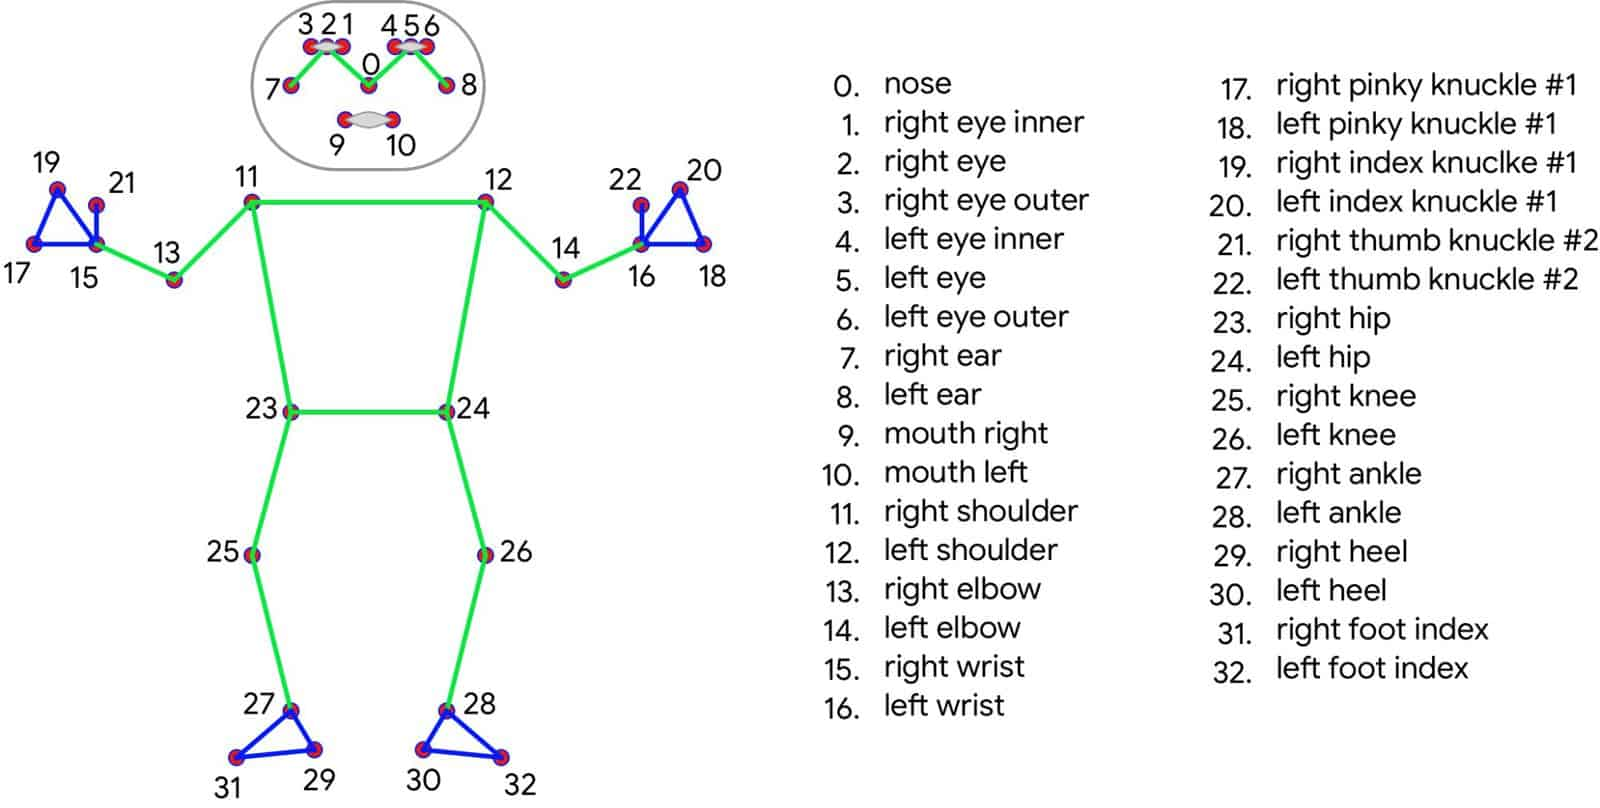

-> I would remove most of the pose landmarks as having many of them do not add much value (hand are largely the most important). As the purpose of the pose landmarks for us is only to have a better understanding of the position and depth (as we know the video have been made with the phone, we clearly don't expect LiDAR quality of the z values for depth), only few points will be sufficient. Therefore after looking at the landmarks positions, I would keep every arm landmark (left and right not to make unparallel data), 4 point of the core body, and 1 of the nose as the middle of the face. Therefore we would keep 11,12,13,14,15,16,17,18,19,20,21,22 (arms), 23,24 (2 lower core body) and 0 (nose). reducing the number of pose landmarks from 32 to 15.

In [151]:
def read_parquet_file(file_path, columns):
    table = pq.read_table(file_path, columns=columns)
    return table.to_pandas()

if __name__ == "__main__":
    columns_of_interest = ['sequence_id',
'frame',
'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20',
'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20',
'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20',
'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20',
'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20',
'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20',
'x_pose_11', 'x_pose_12', 'x_pose_13', 'x_pose_14', 'x_pose_15', 'x_pose_16', 'x_pose_17', 'x_pose_18', 'x_pose_19', 'x_pose_20', 'x_pose_21', 'x_pose_22', 'x_pose_23', 'x_pose_24',
'y_pose_11', 'y_pose_12', 'y_pose_13', 'y_pose_14', 'y_pose_15', 'y_pose_16', 'y_pose_17', 'y_pose_18', 'y_pose_19', 'y_pose_20', 'y_pose_21', 'y_pose_22', 'y_pose_23', 'y_pose_24',
'z_pose_11', 'z_pose_12', 'z_pose_13', 'z_pose_14', 'z_pose_15', 'z_pose_16', 'z_pose_17', 'z_pose_18', 'z_pose_19', 'z_pose_20', 'z_pose_21', 'z_pose_22', 'z_pose_23', 'z_pose_24']
    file_path = 'd:/Bureau/DS/aCapstone/527708222.parquet'

    df = read_parquet_file(file_path, columns_of_interest)
    print(df)

             frame  x_right_hand_0  x_right_hand_1  x_right_hand_2  \
sequence_id                                                          
1880607618       0        0.200624        0.302635        0.427209   
1880607618       1        0.240830        0.374630        0.474594   
1880607618       2        0.235014        0.375686        0.485869   
1880607618       3        0.252615        0.385305        0.487498   
1880607618       4        0.294039        0.405612        0.502041   
...            ...             ...             ...             ...   
1912627838      89        0.266774        0.357957        0.415935   
1912627838      90        0.244922        0.342586        0.392606   
1912627838      91        0.230954        0.339997        0.389223   
1912627838      92        0.215118        0.330285        0.386708   
1912627838      93        0.205112        0.286439        0.359694   

             x_right_hand_3  x_right_hand_4  x_right_hand_5  x_right_hand_6  \
sequence_i

(ps : I first did the below code to import the df though optimized it and the first one is running faster)

In [150]:
# columns_of_interest = ['sequence_id',
# 'frame',
# 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20',
# 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20',
# 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20',
# 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20',
# 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20',
# 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20',
# 'x_pose_11', 'x_pose_12', 'x_pose_13', 'x_pose_14', 'x_pose_15', 'x_pose_16', 'x_pose_17', 'x_pose_18', 'x_pose_19', 'x_pose_20', 'x_pose_21', 'x_pose_22', 'x_pose_23', 'x_pose_24',
# 'y_pose_11', 'y_pose_12', 'y_pose_13', 'y_pose_14', 'y_pose_15', 'y_pose_16', 'y_pose_17', 'y_pose_18', 'y_pose_19', 'y_pose_20', 'y_pose_21', 'y_pose_22', 'y_pose_23', 'y_pose_24',
# 'z_pose_11', 'z_pose_12', 'z_pose_13', 'z_pose_14', 'z_pose_15', 'z_pose_16', 'z_pose_17', 'z_pose_18', 'z_pose_19', 'z_pose_20', 'z_pose_21', 'z_pose_22', 'z_pose_23', 'z_pose_24']

# table = pq.read_table('d:/Bureau/DS/aCapstone/527708222.parquet', columns=columns_of_interest)
# df = table.to_pandas()
# df

,frame,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,...,z_pose_15,z_pose_16,z_pose_17,z_pose_18,z_pose_19,z_pose_20,z_pose_21,z_pose_22,z_pose_23,z_pose_24
sequence_id,,,,,,,,,,,,,,,,,,,,,
1880607618,0,0.200624,0.302635,0.427209,0.531130,0.609704,0.466830,0.621508,0.720132,0.782646,...,-1.302108,-3.539973,-1.474852,-3.907403,-1.535634,-3.809999,-1.356398,-3.542088,-0.162131,0.168272
1880607618,1,0.240830,0.374630,0.474594,0.547350,0.596090,0.453041,0.591468,0.683067,0.740463,...,-1.217129,-3.453761,-1.392152,-3.820710,-1.448803,-3.722886,-1.272418,-3.453108,-0.136024,0.141433
1880607618,2,0.235014,0.375686,0.485869,0.566487,0.630853,0.434785,0.536943,0.621403,0.682213,...,-1.289281,-3.496969,-1.473207,-3.865747,-1.528101,-3.752836,-1.343315,-3.491278,-0.141135,0.146788
1880607618,3,0.252615,0.385305,0.487498,0.563021,0.643407,0.445335,0.525891,0.612506,0.690043,...,-1.315089,-3.530754,-1.544148,-3.898497,-1.631264,-3.794814,-1.388333,-3.529720,-0.146302,0.151999
1880607618,4,0.294039,0.405612,0.502041,0.568720,0.631543,0.479026,0.542870,0.605044,0.662126,...,-1.414783,-3.476186,-1.649805,-3.852440,-1.706104,-3.759690,-1.470669,-3.484234,-0.153527,0.159551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912627838,89,0.266774,0.357957,0.415935,0.442117,0.414395,0.271646,0.259206,0.337859,0.368670,...,-0.790688,-3.709423,-0.908176,-4.073530,-0.998713,-4.036657,-0.841738,-3.745024,-0.145449,0.151864
1912627838,90,0.244922,0.342586,0.392606,0.409731,0.378050,0.240688,0.278423,0.343222,0.337006,...,-0.791185,-3.557929,-0.908804,-3.924031,-1.006292,-3.906580,-0.843471,-3.600282,-0.143819,0.150366
1912627838,91,0.230954,0.339997,0.389223,0.398273,0.359395,0.228129,0.315546,0.352227,0.322500,...,-0.885284,-3.880698,-1.019412,-4.260234,-1.117020,-4.226183,-0.943396,-3.914468,-0.147698,0.154105


## 2. Cleaning <a id="2"></a>

In [152]:
def find_sequence_with_less_than_7_frames(df):
    result = []
    
    # Group the DataFrame by 'sequence_id'
    grouped_df = df.groupby('sequence_id')
    
    # Check the number of frames for each group and keep 'sequence_id' with less than 10 frames
    for sequence_id, group in grouped_df:
        num_frames = len(group)
        if num_frames < 7:
            result.append(sequence_id)
    
    return result

# Find 'sequence_id' where there are less than 10 frames
sequence_id_with_less_than_7_frames = find_sequence_with_less_than_7_frames(df)
print(sequence_id_with_less_than_7_frames)

[1881132954, 1882666468, 1883537586, 1883593601, 1886444093, 1886653732, 1887653118, 1887931884, 1889908635, 1890082763, 1891854143, 1894145417, 1895908535, 1896329012, 1897391592, 1897862208, 1901153392, 1901158972, 1901674631, 1901714824, 1905833890, 1907367092, 1907969585, 1909785125]


Many data have less than 7 frames and particularly exactly 6 frames as we will see of the graph below despite having long labels. They will be cleaned on next code as they have less than 11 frames informations.

After digging further on the labels of those sequences, those are the participant id and the labels of the first 5 of those sequences : 

1881132954 71   sunbelx.com/tatianayucra

1882666468 223  jessica-chastain.com/

1883537586 73   katrina beil

1883593601 203	728-726-7829

1886444093 145	washington-capitals/

There doesn't seem to be any pattern about the participant id, and all the labels are long and would be impossible to understand in such a small amount of frames implying wrong data that we have to remove for clarity to the models.


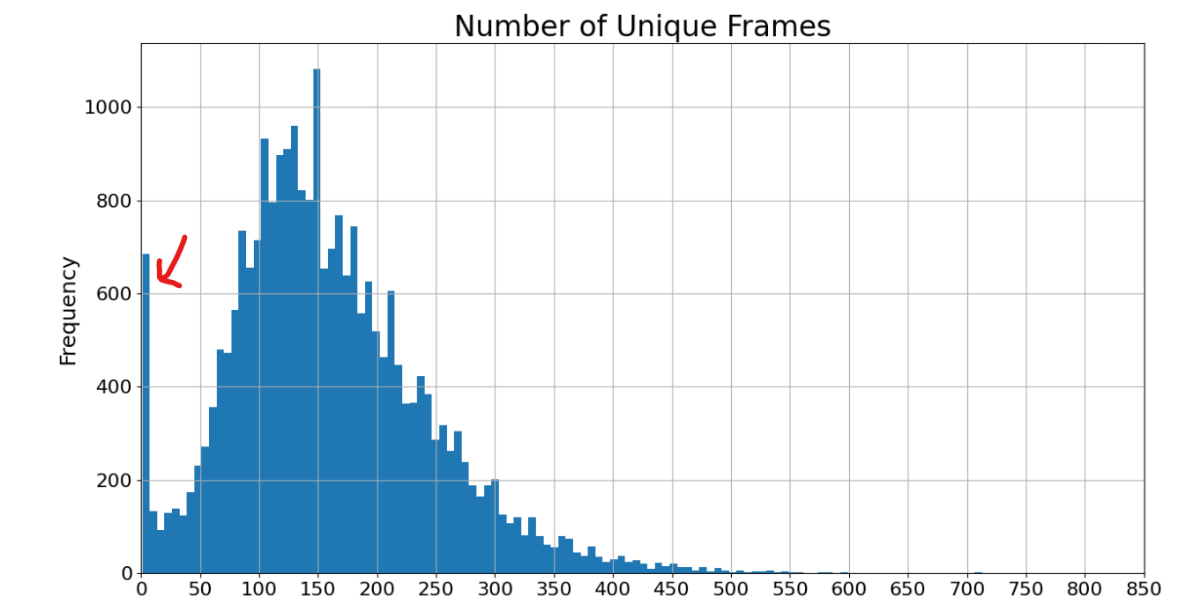

In [154]:
import pandas as pd

# Assuming you have already loaded your DataFrame named 'df'

# Count the number of cases where a specific sequence_id has less than 6 non-NaN values
count = 0
for sequence_id, group in df.groupby('sequence_id'):
    non_nan_count = group[['x_right_hand_0', 'x_left_hand_0']].count().sum()
    if non_nan_count < 11:
        count += 1

print(f"Number of sequence_id with 10 or less non-NaN values: {count}")


Number of sequence_id with 10 or less non-NaN values: 91


In [123]:
sequences_to_drop = []
for sequence_id, group in df.groupby('sequence_id'):
    non_nan_count = group[['x_right_hand_0', 'x_left_hand_0']].count().sum()
    if non_nan_count < 11:
        sequences_to_drop.append(sequence_id)

# Drop rows with 'sequence_id' in the 'sequences_to_drop' list
filtered_df = df[~df.index.isin(sequences_to_drop)]

In [155]:
df.count()

frame             159737
x_right_hand_0     79071
x_right_hand_1     79071
x_right_hand_2     79071
x_right_hand_3     79071
                   ...  
z_pose_20         159737
z_pose_21         159737
z_pose_22         159737
z_pose_23         159737
z_pose_24         159737
Length: 169, dtype: int64

In [127]:
filtered_df.count()

frame             153625
x_right_hand_0     78684
x_right_hand_1     78684
x_right_hand_2     78684
x_right_hand_3     78684
                   ...  
z_pose_20         153625
z_pose_21         153625
z_pose_22         153625
z_pose_23         153625
z_pose_24         153625
Length: 169, dtype: int64

For the pupose of Padding later(as we want to have an identical number of rows for each sequence, to improve model efficiency. For example CNN expect the shape of the df to be uniform), we will remove every outliers that have too many frames as well, and will only remove those with more than 400 frames for now. (could later clean those form 250 -400 and reduce it to 250 to set max length at 250 instead and this way reducing largely the number of rows with its 0)

In [156]:
max_length = 350  # Maximum sequence length to keep

# Create a mask to identify sequence_id values with more than 349 frames
mask = filtered_df.groupby('sequence_id').apply(lambda group: len(group) > max_length)

# Get the sequence_id values that need to be removed
sequence_ids_to_remove = mask[mask].index.get_level_values('sequence_id').tolist()

# Filter the original DataFrame to keep only the desired sequence_id values
filtered_df2 = filtered_df[~filtered_df.index.get_level_values('sequence_id').isin(sequence_ids_to_remove)]

# Display the filtered DataFrame
print(filtered_df2)

             frame  x_right_hand_0  x_right_hand_1  x_right_hand_2  \
sequence_id                                                          
1880607618       0        0.200624        0.302635        0.427209   
1880607618       1        0.240830        0.374630        0.474594   
1880607618       2        0.235014        0.375686        0.485869   
1880607618       3        0.252615        0.385305        0.487498   
1880607618       4        0.294039        0.405612        0.502041   
...            ...             ...             ...             ...   
1912627838      89        0.266774        0.357957        0.415935   
1912627838      90        0.244922        0.342586        0.392606   
1912627838      91        0.230954        0.339997        0.389223   
1912627838      92        0.215118        0.330285        0.386708   
1912627838      93        0.205112        0.286439        0.359694   

             x_right_hand_3  x_right_hand_4  x_right_hand_5  x_right_hand_6  \
sequence_i

In [158]:
filtered_df2.count()

frame             141042
x_right_hand_0     73115
x_right_hand_1     73115
x_right_hand_2     73115
x_right_hand_3     73115
                   ...  
z_pose_20         141042
z_pose_21         141042
z_pose_22         141042
z_pose_23         141042
z_pose_24         141042
Length: 169, dtype: int64

-> 73 115 right hand 
-> 13835 left hand 
-> 141 042 pose (= to number of row as no missing data)

In [160]:
num_distinct_sequence_ids = filtered_df2.index.nunique()

print("Number of distinct sequence_id values:", num_distinct_sequence_ids)

Number of distinct sequence_id values: 877


ps : I first have put the max at 400, it ended up with 359 200 instead of 306 950 here. There is 21 sequence having between 350 and 400 frames.

### 3. Possibility of augmentation <a id="3"></a>

This would be a function to augment efficiently our data for random affine (cf : the 2nd place of the previous ASL competition)
https://github.com/ffs333/2nd_place_GISLR

### The main 3 effects on the data here is an adjustment of the scaling, some minor shift and a +- 16 degree adjustment.
For the CNN in more specific, we could add some basic mixup augmentations
Add some new features that our model would have issues to learn by itself. Including angles.

In [ ]:
#Code for Augmentation
def do_random_affine(xyz, scale=(0.8, 1.3), shift=(-0.08, 0.08), degree=(-16, 16), p=0.5):
    if scale is not None:
        scale = np.random.uniform(*scale)
        xyz = scale*xyz

    if shift is not None:
        shift = np.random.uniform(*shift)
        xyz = xyz + shift

    if degree is not None:
        degree = np.random.uniform(*degree)
        radian = degree/180*np.pi
        c = np.cos(radian)
        s = np.sin(radian)
        rotate = np.array([
            [c,-s],
            [s, c],
        ]).T
        xyz[..., :2] = xyz[..., :2] @rotate

    return xyz

Some added information :

In [ ]:
# 2.1 Common Augmentations
# These augmentations are used in both CNN training and transformer training

# Random affine: Same as @hengck23 shared. In CNN, after global affine, shift-scale-rotate was also applied to each part separately (e.g. hand, lip, body-pose).

# Random interpolation: Slightly scale and shift the time dimension.

# Flip pose: Flip the x-coordinates of all points. In CNN, x_new = x_max - x_old. In transformer, x_new = 2 * frame[:,0,0] - x_old.

# Finger tree rotate: There are 4 root-children pairs in a finger with 5-vertices. E.g. in thumb ([0,1,2,3,4]), these 4 root-children pairs are: 0-[1,2,3,4],1-[2,3,4],2-[3,4],3-[4]. We randomly choose some of these pairs, and rotate the children points around root point with a small random angle.

# 2.2 CNN Specific Augmentations
# Mixup: Implement basic mixup augmentation (only works with CNNs, not transformers).
# Replace augmentation: Replace some random parts from other samples of the same class.
# Time and frequence masking: This basic torchaudio augmentation works exceptionally well.
# freq_m = torchaudio.transforms.FrequencyMasking(80)  # it's time axis
# time_m = torchaudio.transforms.TimeMasking(18)       # it's points axis

### 4. Scaling the data <a id="4"></a>

This part has been the hardest to understand to scale in an optimal way. 

Infos

Preprocessing 1st place

Below their preprocessing code

In [ ]:
# class Preprocess(tf.keras.layers.Layer):
#     def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
#         super().__init__(**kwargs)
#         self.max_len = max_len
#         self.point_landmarks = point_landmarks

#     def call(self, inputs):
#         if tf.rank(inputs) == 3:
#             x = inputs[None,...]
#         else:
#             x = inputs

#         mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
#         mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
#         x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
#         std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)

#         x = (x - mean)/std

#         if self.max_len is not None:
#             x = x[:,:self.max_len]
#         length = tf.shape(x)[1]
#         x = x[...,:2]

#         dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

#         dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

#         x = tf.concat([
#             tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
#             tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
#             tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
#         ], axis = -1)

#         x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

#         return x

And this one below from the 6th place : 

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Preprocessing(nn.Module):
#     """
#     Preprocessing module for data preparation.
#     Module is compatible with onnx conversion, hence some weird operations.
    
#     Attributes:
#         type_embed (torch.Tensor): Type embeddings.
#         landmark_embed (torch.Tensor): Landmark embeddings.
#         ids (torch.Tensor): Landmark IDs.
#         to_avg (List[torch.Tensor]): IDs of landmarks to average.
#         hands (torch.Tensor): IDs of hand landmarks.
#         frames (torch.Tensor): Frame numbers.
#         max_len (torch.Tensor): Maximum length.
        
#     Methods:
#         __init__(self, type_embed, max_len=50): Constructor.
#         filter_sign(self, x): Filters sign data by removing frames with missing hand landmarks,
#             and striding the sequence to a small enough dimension.
#         forward(self, x): Preprocesses the input sign data.
#     """
#     def __init__(self, type_embed, max_len=50):
#         """
#         Constructor.

#         Args:
#             type_embed (numpy array): Type embeddings.
#             max_len (int, optional): Maximum length. Defaults to 50.
#         """
#         super(Preprocessing, self).__init__()

#         self.type_embed = torch.from_numpy(type_embed[None, :].astype(np.float32))
#         self.type_embed = self.type_embed.repeat(1000, 1)

#         self.landmark_embed = torch.tensor(np.arange(120)).float().unsqueeze(0) + 1
#         self.landmark_embed = self.landmark_embed.repeat(1000, 1)
        
#         self.ids = torch.from_numpy(np.concatenate(KEPT_LANDMARKS))
#         self.to_avg = [torch.tensor(avg) for avg in TO_AVG]

#         self.hands = torch.tensor(
#             [468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488] + 
#             [522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542]
#         )
#         self.frames = torch.tensor(np.arange(1000) + 1)
#         self.max_len = torch.tensor([max_len])

#     def filter_sign(self, x):
#         """
#         Filters sign data by removing frames with missing hand landmarks,
#         and striding the sequence to a small enough dimension.

#         Args:
#             x (torch.Tensor): Sign data.

#         Returns:
#             torch.Tensor: Filtered sign data.
#         """
#         hands = x[:, self.hands, 0]
#         nan_prop = torch.isnan(hands).float().mean(-1)
#         x = x[torch.where(nan_prop < 1)[0]]

#         length = self.frames[:x.size(0)].max().unsqueeze(0)
#         sz = torch.cat([length, self.max_len]).max()
        
#         divisor = (((sz - self.max_len) > 0) * (sz / self.max_len) + 1).int()
#         ids = (self.frames[:x.size(0)] % divisor) == 0
        
#         return x[ids]

#     def forward(self, x): 
#         """
#         Forward pass of the preprocessing module.

#         Args:
#             x (torch.Tensor): Input sign data.

#         Returns:
#             torch.Tensor: Processed sign data.
#         """
#         x = self.filter_sign(x)
            
#         n_frames = x.shape[0]     
        
#         avg_ids = []
#         for ids in self.to_avg:
#             avg_id = x[:, ids].mean(1, keepdims=True)
#             avg_ids.append(avg_id)

#         x = torch.cat([x[:, self.ids]] + avg_ids, 1)

#         type_embed = self.type_embed[:n_frames]
#         landmark_embed = self.landmark_embed[:n_frames, :x.shape[1]]
        
#         # Normalize & fill nans
#         nonan = x[~torch.isnan(x)].view(-1, x.shape[-1])
#         x = x - nonan.mean(0)[None, None, :]
#         x = x / nonan.std(0, unbiased=False)[None, None, :]
#         x[torch.isnan(x)] = 0

#         # Concat
#         x = torch.cat([
#             type_embed.unsqueeze(-1).to(x.device), x # , landmark_embed.unsqueeze(-1)
#         ], -1).transpose(1, 2)
        
#         return 

### 5. Filling NaN by 0 <a id="5"></a>

The simple formula below does a great job. 

In [161]:
filtered_df_filled = filtered_df.fillna(0)

# Print the updated DataFrame
print(filtered_df_filled.tail(10))

             frame  x_right_hand_0  x_right_hand_1  x_right_hand_2  \
sequence_id                                                          
1912627838      84        0.000000        0.000000        0.000000   
1912627838      85        0.248679        0.352914        0.401294   
1912627838      86        0.000000        0.000000        0.000000   
1912627838      87        0.000000        0.000000        0.000000   
1912627838      88        0.275645        0.368307        0.432001   
1912627838      89        0.266774        0.357957        0.415935   
1912627838      90        0.244922        0.342586        0.392606   
1912627838      91        0.230954        0.339997        0.389223   
1912627838      92        0.215118        0.330285        0.386708   
1912627838      93        0.205112        0.286439        0.359694   

             x_right_hand_3  x_right_hand_4  x_right_hand_5  x_right_hand_6  \
sequence_id                                                                   
1

### 6. Padding  <a id="6"></a>

In [164]:
max_length = 350

# Create an empty DataFrame to store the padded sequences
padded_sequences = []

# Iterate through each unique sequence_id
for sequence_id, sequence_data in filtered_df2.groupby(level='sequence_id'):
    current_length = len(sequence_data)

    # Calculate the number of rows to add for padding
    padding_rows = max_length - current_length
    
    if padding_rows > 0:
        # Create padding data with zeros
        padding_data = pd.DataFrame([[0] * len(filtered_df2.columns)] * padding_rows, columns=filtered_df2.columns)
        
        # Set the index of the padding data to match the original sequence_id
        padding_data.index = [sequence_id] * padding_rows
        
        # Increment the frame number by 1 for each row of padding data
        padding_data['frame'] = range(current_length + 1, current_length + padding_rows + 1)
        
        # Concatenate the original sequence data with the padding data
        padded_sequence = pd.concat([sequence_data, padding_data])
    else:
        padded_sequence = sequence_data
    
    # Append the padded sequence to the padded sequences list
    padded_sequences.append(padded_sequence)

# Combine all padded sequences into a single DataFrame
padded_df = pd.concat(padded_sequences)

# Display the padded DataFrame
print(padded_df)

            frame  x_right_hand_0  x_right_hand_1  x_right_hand_2  \
1880607618      0        0.200624        0.302635        0.427209   
1880607618      1        0.240830        0.374630        0.474594   
1880607618      2        0.235014        0.375686        0.485869   
1880607618      3        0.252615        0.385305        0.487498   
1880607618      4        0.294039        0.405612        0.502041   
...           ...             ...             ...             ...   
1912627838    346        0.000000        0.000000        0.000000   
1912627838    347        0.000000        0.000000        0.000000   
1912627838    348        0.000000        0.000000        0.000000   
1912627838    349        0.000000        0.000000        0.000000   
1912627838    350        0.000000        0.000000        0.000000   

            x_right_hand_3  x_right_hand_4  x_right_hand_5  x_right_hand_6  \
1880607618        0.531130        0.609704        0.466830        0.621508   
1880607618     

(ps : i first did the one below but after optimizing, the code i kept runs almost twice faster.)

In [ ]:
# max_length = 400

# # Create an empty DataFrame to store the padded sequences
# padded_sequences = []

# # Iterate through each unique sequence_id
# for sequence_id in filtered_df2.index.unique():
#     sequence_data = filtered_df2.loc[sequence_id]
#     current_length = len(sequence_data)

#     # Calculate the number of rows to add for padding
#     padding_rows = max_length - current_length
    
#     # Create padding data with zeros
#     padding_data = pd.DataFrame([[0] * len(filtered_df2.columns)] * padding_rows, columns=filtered_df2.columns)
    
#     # Set the index of the padding data to match the original sequence_id
#     padding_data.index = [sequence_id] * padding_rows
    
#     # Increment the frame number by 1 for each row of padding data
#     padding_data['frame'] = range(current_length + 1, current_length + padding_rows + 1)
    
#     # Concatenate the original sequence data with the padding data
#     padded_sequence = pd.concat([sequence_data, padding_data])
    
#     # Append the padded sequence to the padded sequences list
#     padded_sequences.append(padded_sequence)

# # Combine all padded sequences into a single DataFrame
# padded_df = pd.concat(padded_sequences)

# # Display the padded DataFrame
# print(padded_df)

In [141]:
padded_df.tail(412)

,frame,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,...,z_pose_15,z_pose_16,z_pose_17,z_pose_18,z_pose_19,z_pose_20,z_pose_21,z_pose_22,z_pose_23,z_pose_24
1912612641,389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912612641,390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912612641,391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912612641,392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912612641,393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912627838,396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912627838,397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912627838,398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1912627838,399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
print(padded_df.shape)

(306950, 169)


In [166]:
num_distinct_sequence_ids = padded_df.index.nunique()

print("Number of distinct sequence_id values:", num_distinct_sequence_ids)

Number of distinct sequence_id values: 877


In global, I have been conservateur and kept the large majority of the data. As we can see here we have 877 out of 1000 sequence_id after preprocessing. There is 21 data point from 350 and 400 frames that we removed. Next step later would be to keep them while reformatting them for being at 350 frames. We could want to reduce the maximum number of frames from 350 to 300 or 250 for calculations efficiency.

## `Below some extra information from some of the solutions used on the previous competition dealing with Sign Language words recognition`

## The main useful information found from the top 10 solutions of the last ASL competition (on which it was about ASL word classification instead of letter recognition and combination):

Preprocessing 2nd place

1.1 CNN Preprocessing
We extracted 18 lip points, 20 pose points (including arms, shoulders, eyebrows, and nose), and all hand points, resulting in a total of 80 points.
During training, we applied various augmentations.
We implemented standard normalization.
Instead of dropping NaN values, we filled them with zeros after normalization.
We interpolated the time axis to a size of 160 using 'nearest' interpolation: yy = F.interpolate(yy[None, None, :], size=self.new_size, mode='nearest').
Finally, we obtained a tensor with dimensions 160x80x3, where 3 represents the (X, Y, Z) axes. 

Preprocessing
1.2 Transformer Preprocessing
Only 61 points were kept, including 40 lip points and 21 hand points. For left and right hand, the one with less NaN was kept. If right hand was kept, mirror it to left hand.

Augmentations, normalization and NaN-filling were applied sequentially.

Sequences longer than 96 were interpolated to 96. Sequences shorter than 96 were unchanged.

Apart from raw positions, hand-crafted features were also used, including motion, distances, and cosine of angles.

Motion features consist of future motion and history motion, which can be denoted as:



Full 210 pairwise distances among 21 hand points were included.

There are 5 vertices in a finger (e.g. thumb is [0,1,2,3,4]), and therefore, there are 3 angles: <0,1,2>, <1,2,3>, <2,3,4>. So 15 angles of 5 fingers were included.

Randomly selected 190 pairwise distances and randomly selected 8 angles among 40 lip points were included.

Preprocessing 4th place

Use XY coordinates
Normalize the coordinates between the eyebrows to (0,0).
Compare the number of frames detected for the right and left hands, and flip only when the number of frames detected for the right hand is less than that of the left hand (x=-x).
Use XY coordinates of 21 feature points of the right hand (flip left hand) and 40 feature points of the lips, for a total of 122 dimensions.
Delete frames in which the feature points of the hand have not been detected. Therefore, the number of frames for the hand and the number of frames for the lips will be different."

Preprocessing 6th place

Remove frames without fingers
Stride the sequence (use 1 every n frames) such that the sequence size is <= max_len. We used max_len=25 and 80 in the final ensemble
Normalization is done for the whole sequence to have 0 mean and 1 std. We do an extra centering before the specific MLP. Nan values are set to 0

https://github.com/TheoViel/kaggle_islr

In [23]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Preprocessing(nn.Module):
#     """
#     Preprocessing module for data preparation.
#     Module is compatible with onnx conversion, hence some weird operations.
    
#     Attributes:
#         type_embed (torch.Tensor): Type embeddings.
#         landmark_embed (torch.Tensor): Landmark embeddings.
#         ids (torch.Tensor): Landmark IDs.
#         to_avg (List[torch.Tensor]): IDs of landmarks to average.
#         hands (torch.Tensor): IDs of hand landmarks.
#         frames (torch.Tensor): Frame numbers.
#         max_len (torch.Tensor): Maximum length.
        
#     Methods:
#         __init__(self, type_embed, max_len=50): Constructor.
#         filter_sign(self, x): Filters sign data by removing frames with missing hand landmarks,
#             and striding the sequence to a small enough dimension.
#         forward(self, x): Preprocesses the input sign data.
#     """
#     def __init__(self, type_embed, max_len=50):
#         """
#         Constructor.

#         Args:
#             type_embed (numpy array): Type embeddings.
#             max_len (int, optional): Maximum length. Defaults to 50.
#         """
#         super(Preprocessing, self).__init__()

#         self.type_embed = torch.from_numpy(type_embed[None, :].astype(np.float32))
#         self.type_embed = self.type_embed.repeat(1000, 1)

#         self.landmark_embed = torch.tensor(np.arange(120)).float().unsqueeze(0) + 1
#         self.landmark_embed = self.landmark_embed.repeat(1000, 1)
        
#         self.ids = torch.from_numpy(np.concatenate(KEPT_LANDMARKS))
#         self.to_avg = [torch.tensor(avg) for avg in TO_AVG]

#         self.hands = torch.tensor(
#             [468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488] + 
#             [522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542]
#         )
#         self.frames = torch.tensor(np.arange(1000) + 1)
#         self.max_len = torch.tensor([max_len])

#     def filter_sign(self, x):
#         """
#         Filters sign data by removing frames with missing hand landmarks,
#         and striding the sequence to a small enough dimension.

#         Args:
#             x (torch.Tensor): Sign data.

#         Returns:
#             torch.Tensor: Filtered sign data.
#         """
#         hands = x[:, self.hands, 0]
#         nan_prop = torch.isnan(hands).float().mean(-1)
#         x = x[torch.where(nan_prop < 1)[0]]

#         length = self.frames[:x.size(0)].max().unsqueeze(0)
#         sz = torch.cat([length, self.max_len]).max()
        
#         divisor = (((sz - self.max_len) > 0) * (sz / self.max_len) + 1).int()
#         ids = (self.frames[:x.size(0)] % divisor) == 0
        
#         return x[ids]

#     def forward(self, x): 
#         """
#         Forward pass of the preprocessing module.

#         Args:
#             x (torch.Tensor): Input sign data.

#         Returns:
#             torch.Tensor: Processed sign data.
#         """
#         x = self.filter_sign(x)
            
#         n_frames = x.shape[0]     
        
#         avg_ids = []
#         for ids in self.to_avg:
#             avg_id = x[:, ids].mean(1, keepdims=True)
#             avg_ids.append(avg_id)

#         x = torch.cat([x[:, self.ids]] + avg_ids, 1)

#         type_embed = self.type_embed[:n_frames]
#         landmark_embed = self.landmark_embed[:n_frames, :x.shape[1]]
        
#         # Normalize & fill nans
#         nonan = x[~torch.isnan(x)].view(-1, x.shape[-1])
#         x = x - nonan.mean(0)[None, None, :]
#         x = x / nonan.std(0, unbiased=False)[None, None, :]
#         x[torch.isnan(x)] = 0

#         # Concat
#         x = torch.cat([
#             type_embed.unsqueeze(-1).to(x.device), x # , landmark_embed.unsqueeze(-1)
#         ], -1).transpose(1, 2)
        
#         return 

Preprocessing 8th place

Preprocessing

Linear interpolation of longer sequences to max length of 96.
Normalise each body part, using min max - I found this better than mean/std. In one model I used mean/std for diversity.
Create time shift delta features on a subset of points, using time shifts of [1, 2, 3, 4, 6, 8, 12, 16]. It was important to forward fill NANs as opposed to 0-fill.
Angle features between xyz position, and xy positions, on a few different joints - corner of mouth, hand, arms.
Some point to point distances, interestingly this did not help much.

Preprocessing 10th place

Find target hand using nan in time dimension, flip if need, select poses where target hand is not nan, resize to 16 in time dimension, and finally normalize with

xyz = (xyz - np.nanmean(xyz[:,FACE,:],axis(0,1))) / np.nanstd(xyz[:,FACE,:],axis=(0,1))

#### Original facts found : 

Someone made a bug in a code that led to a better performance, when implementing a mixup augmentation it did this in the model forward pass function, -

if np.random.randn() < 0.5 and mode_flag == 'train':
    x, labels_ohe = self.mixup(x,labels_ohe)
Later he found out that using normal distribution instead of a uniform one thus if we imagine a PDF of normal disribution, we can say that we are using mixup in ~70% of cases, and when corrected it, the performance dropped! (so it's better to use mixup with higher probability)

### Some useful code for later

Some other possibility of augmentation (half explaination, half code) :

In [ ]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) #define the name of the environment
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def get_strategy(device='TPU'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')
    
    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy()

## Summary
- removing the non useful pose informations (keep 15/32 being arms, chest, nose for center)
- removing every sequence that has less or equal than 6 frame with informations on hand position (last majority of them have dirty data, and 97.5 % of our data has more than 10 characters, we would expect about 3 frames per character to have a decent chance to predict it, removing the <= 10 frames is a safe thing to do and will improve the speed of the models)
- Remove every missing data by 0 after normalization (as cnn and transformers deal well with it, and don't disrupt the flow of the sequence)
- Idea : If there is more left hand positions than right hand, then we could consider the signer as left handed. We could mirror the left hand data to right hand. This way we transform all data artificially to right handed preprocessing what will reduce the runtime of models. (to make it mirror we should 'mirror' the pose and the position of the hand. Had some thoughts on this, still thinking on how the transposition of the landmarks would be and how to make it mirroring accurately. As well as how would it react with the test data. (maybe we just add a function on the model that swith the interest of column from right to left hand if there is more hand position on left.)